#### This program computes the linear regression coefficients and intercept to predict the Zn Drop in  106TK01 from the following features:
1. dezn flow
2. dezn feed temp
3. 105tk05 temp
4. H2S flow
5. ntrl pls condition
Ridge regression is used.


This is a continuation from the ZnDrop_Proj_Load_Data_Gathered_2017_to_2020Aug.ipynb file

In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.parser import parse
from itertools import compress
from collections import OrderedDict
from datetime import date
import datetime
from datetime import timedelta
import re

import openpyxl
import random

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
#used in the analysis results data. cleans up the sampling time entry
def time_cleaner(x):
    time_regex = re.compile(r'[0-8a-zA-Z:]', re.IGNORECASE| re.VERBOSE|re.DOTALL)
    timeact = time_regex.findall(x)
    newtime = ''.join(timeact)
    t = parse(x)
    new_str_time = str(t.hour)+':'+str(t.minute)+':'+str(t.second)
    return new_str_time
def ave_filler(dfname, colname):
    dfcn = dfname[colname]
    try:        
        dfcn = pd.to_numeric(dfcn, errors='coerce')
    except:
        print('error found in' + str(colname))
        pass
    try:
        dfname[colname] = dfcn.where(dfcn.notnull(), other=(dfcn.fillna(method='ffill') + dfcn.fillna(method='bfill'))/2)
    except:
        print('nan not fixed' + str(colname))   
    return dfname
def generate_df_from_analysis(workbookTab, col_sampleDate, col_sampleTime, col_analysis, col_title):
    #get the start and end sample dates
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
    #gets the date day from the B column of the analysis file if there is value in the cell
    for i in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
            Smpl_day_index.append(i)
    #get the ending row that has date day
    for j in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
            smpl_end_index = j
    for y in range(0, len(Smpl_day_index)):
        if Smpl_day_index[y] != Smpl_day_index[-1]:      
            for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                if workbookTab[str(col_analysis)+str(x)].value is None: 
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

        if Smpl_day_index[y] == Smpl_day_index[-1]:
            for x in range(Smpl_day_index[y], smpl_end_index+1):
                if workbookTab[str(col_analysis)+str(x)].value is None:   
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

    Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
    Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
    Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
    Chem_Element_df.set_index('DATETIME', inplace=True)

    return Chem_Element_df

def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)
#---------------------------------------

class LabResults():
    def __init__(self, monthyear, filePath):
        #____monthyear format examle is datetime.date(2020,7,1)
        #____filepath example is '\\thgobna001\userdata\THPAL\...\ANALYSIS RESULTS 2020\7) July _2020.xlsx'
        #____add r' at the start of the filepath to apply the regex that allows the use of the filepath as raw
        #____sef.workbook is the uploaded excel workbook of the entire analysis files so it takes time to load
        #____Create an instance of the workbook by giving it a varible name with the sample format: Jan_2020
        
        import openpyxl
        import io
        with open(filePath, "rb") as f:
            in_mem_file = io.BytesIO(f.read())
        
        self.workbook = openpyxl.load_workbook(in_mem_file, data_only=True)
        self.monthyear = monthyear   
        
    def generate_df_from_analysis(self, tabname, list_lab_index):
        #____tabname is a string type name of the tab in the laboratory analysis excel file.
        #____-------Example tabnames: '104PU01', '105TK03', '106TK01'
        #____-------Inside these tabs are the specific analysis results done on the sample taken from the 'tabname' area .
        #____list_lab_index is a list with the sample format is: ['B', 'C', 'E', '104_Pb']
        #____-------the first letter 'B' is the column letter where the day of the month is written as integers 1,2,3..30
        #____-------the second letter 'C' is the column letter where the sampling time is written; e.g. '7:00:00 AM'
        #____-------the third letter 'E' is the column where the results of the specific analysis are listed
        #____-------the last item in the list is the string you'll use as the new title; e.g. '104_Pb'
        
        workbookTab = self.workbook[tabname]
        self.list_lab_index = list_lab_index
        col_sampleDate = self.list_lab_index[0]
        col_sampleTime = self.list_lab_index[1]
        col_analysis = self.list_lab_index[2]
        col_title = self.list_lab_index[3]
        currentmonthyr = self.monthyear
        
        #get the start and end sample dates
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
        #gets the date day from the B column of the analysis file if there is value in the cell
        for i in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
                Smpl_day_index.append(i)
        #get the ending row that has date day
        for j in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
                smpl_end_index = j
        for y in range(0, len(Smpl_day_index)):
            if Smpl_day_index[y] != Smpl_day_index[-1]:      
                for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                    if workbookTab[str(col_analysis)+str(x)].value is None: 
                        pass
                    else:
                        try:
                            if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                                date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))  
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                            else:
                                date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))  
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                        except:
                            pass

            if Smpl_day_index[y] == Smpl_day_index[-1]:
                for x in range(Smpl_day_index[y], smpl_end_index+1):
                    if workbookTab[str(col_analysis)+str(x)].value is None:   
                        pass
                    else:
                        try:
                            if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                                date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                            else:
                                date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                        except:
                            pass

        Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
        Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
        Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
        Chem_Element_df.set_index('DATETIME', inplace=True)

        return Chem_Element_df
    
def join_DF(dfsList1):
    df = dfsList1[0]
    for i in range(1,len(dfsList1)):
        df = df.join(dfsList1[i], how='outer')
    return df

def append_monthsDF(dfsListmonthly): #takes the list of dataframes from monthly lab results of one sampling area
    df = dfsListmonthly[0]
    for i in range(1,len(dfsListmonthly)):
        df = df.append(dfsListmonthly[i], ignore_index=True)
    return df    

In [3]:
#-------Load the DF_combined data from ZnDrop_Proj_Load_Data_Gathered_2017_to_2020Aug.ipynb file

DF_NTRL_TK0513_MSTK01 = pd.read_excel(r'C:\Users\v.t.flores\Documents\df_ZnDrop_project_105TK05_2017_2020_PIdata.xlsx')

DF_NTRL_TK0513_MSTK01_1 = DF_NTRL_TK0513_MSTK01.set_index('DATETIME')

#convert the df to numeric
for i in DF_NTRL_TK0513_MSTK01_1.columns:
    DF_NTRL_TK0513_MSTK01_1[i] = pd.to_numeric(DF_NTRL_TK0513_MSTK01_1[i], errors='coerce')
#
#
#-------------note that we use the interpolate to fill in missing values with linear interpolation
#
DF_NTRL_TK0513_MSTK01_2 = DF_NTRL_TK0513_MSTK01_1.interpolate(method='linear', limit_direction='forward', axis=0)    

DF_105 = DF_NTRL_TK0513_MSTK01_2[DF_NTRL_TK0513_MSTK01_2.columns[20:32]] #---------slice the data and create a copy of the 105 data columns as a dataframe
DF_105_r = DF_105.reset_index()                                          #---------reset the index to prepare it to be added by the retention time
DF_105_r['DATETIME'] = DF_105_r['DATETIME'] + datetime.timedelta(hours=1) #--------add the retention time of 1h for this trial (this is saying, "after 1hr the solution from ntrl will be sampled in 105tk05")
DF_105 = DF_105_r.set_index('DATETIME')                                   #--------set the datetime column as the index. ready for joining with the rest of the retention t adjusted datasets

DF_106 = DF_NTRL_TK0513_MSTK01_2[[DF_NTRL_TK0513_MSTK01_2.columns[-1]]] #---------------------------------slice the data and create a copy of the zndrop column as a dataframe
DF_106_r = DF_106.reset_index()
DF_106_r['DATETIME'] = DF_106_r['DATETIME'] + datetime.timedelta(hours=2)
DF_106 = DF_106_r.set_index('DATETIME')

#Prepare the DF for remixing the Rtime adjusted data into the main df.
DF_NTRL_TK0513_MSTK01_2_drop105_106 = DF_NTRL_TK0513_MSTK01_2.drop(DF_NTRL_TK0513_MSTK01_2.columns[20:32], axis=1)  #---------------------------Drop the columns related to 105tk05 samples from the Main DF: DF_NTRL_TK0513_MSTK01_2
DF_NTRL_TK0513_MSTK01_2_drop105_106 = DF_NTRL_TK0513_MSTK01_2_drop105_106.drop(DF_NTRL_TK0513_MSTK01_2_drop105_106.columns[-1], axis=1) #-------Drop the columns related to 106 sample from the Main DF. This the zn_drop value

# Remix the dropped and time adjusted columns
#DF_NTRL_TK0513_MSTK01_3 is the time adjusted dataframe
DF_NTRL_TK0513_MSTK01_3 = DF_NTRL_TK0513_MSTK01_2_drop105_106.join(DF_106, how='outer').join(DF_105, how='outer')

for col in DF_NTRL_TK0513_MSTK01_3.columns:
    DF_NTRL_TK0513_MSTK01_3[col] = pd.to_numeric(DF_NTRL_TK0513_MSTK01_3[col], errors='coerce')

DF_NTRL_TK0513_MSTK01_4 = DF_NTRL_TK0513_MSTK01_3.dropna()

DF_NTRL_TK0513_MSTK01_4['Zn_drop_act'] = DF_NTRL_TK0513_MSTK01_4['Zn_drop_act']*100

zndrop_predictors = ['104_Pb', '104_Zn', '104_Cu', '104_Ni', '104_Co', '104_Fe', '104_Mn',
       '104_Cr', '104_Ca', '104_Si', '104_Al', '104_Mg', '104_Fe2', '104_pH60',
       '104_ORP', '104_NTU', '104_Ft', 'tk13_Zn', 'tk13_solids%',
       'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'DeZn_Seed_Flow', 'DeZn_TK05_T',
       'H2S_tk01', 'H2S_tk02', 'tk05_Al', 'tk05_Ca', 'tk05_Co', 'tk05_Cr',
       'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni', 'tk05_Pb',
       'tk05_Si', 'tk05_Zn']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### For 2014-16 data

In [4]:
# Load data from ZnDrop_Proj_Load_Data_Gathered_2014_to_2016.ipynb. It's the excel file exported from this ipynb

DF_NTRL_TK0513_MSTK01_2014_2016 = pd.read_excel(r'C:\Users\v.t.flores\Documents\df_ZnDrop_project_105TK05_2014_2016_PIdata.xlsx')

DF_NTRL_TK0513_MSTK01_2014_2016_1 = DF_NTRL_TK0513_MSTK01_2014_2016.set_index('DATETIME')

#convert the df to numeric
for i in DF_NTRL_TK0513_MSTK01_2014_2016_1.columns:
    DF_NTRL_TK0513_MSTK01_2014_2016_1[i] = pd.to_numeric(DF_NTRL_TK0513_MSTK01_2014_2016_1[i], errors='coerce')
#
#
#-------------note that we use the interpolate to fill in missing values with linear interpolation
#
DF_NTRL_TK0513_MSTK01_2014_2016_1_2 = DF_NTRL_TK0513_MSTK01_2014_2016_1.interpolate(method='linear', limit_direction='forward', axis=0)    


DF_105_1516 = DF_NTRL_TK0513_MSTK01_2014_2016_1_2[DF_NTRL_TK0513_MSTK01_2014_2016_1_2.columns[21:33]] #---------slice the data and create a copy of the 105 data columns as a dataframe
DF_105_1516r = DF_105_1516.reset_index()                                          #---------reset the index to prepare it to be added by the retention time
DF_105_1516r['DATETIME'] = DF_105_1516r['DATETIME'] + datetime.timedelta(hours=1) #--------add the retention time of 1h for this trial (this is saying, "after 1hr the solution from ntrl will be sampled in 105tk05")
DF_105_1516 = DF_105_1516r.set_index('DATETIME')                                   #--------set the datetime column as the index. ready for joining with the rest of the retention t adjusted datasets

DF_106_1516 = DF_NTRL_TK0513_MSTK01_2014_2016_1_2[[DF_NTRL_TK0513_MSTK01_2014_2016_1_2.columns[-1]]] #---------------------------------slice the data and create a copy of the zndrop column as a dataframe
DF_106_1516r = DF_106_1516.reset_index()
DF_106_1516r['DATETIME'] = DF_106_1516r['DATETIME'] + datetime.timedelta(hours=2)
DF_106_1516 = DF_106_1516r.set_index('DATETIME')

#Prepare the DF for remixing the Rtime adjusted data into the main df.
DF_NTRL_TK0513_MSTK01_2_201516_drop105_106 = DF_NTRL_TK0513_MSTK01_2014_2016_1_2.drop(DF_NTRL_TK0513_MSTK01_2014_2016_1_2.columns[21:33], axis=1)  #---------------------------Drop the columns related to 105tk05 samples from the Main DF: DF_NTRL_TK0513_MSTK01_2
DF_NTRL_TK0513_MSTK01_2_201516_drop105_106 = DF_NTRL_TK0513_MSTK01_2_201516_drop105_106.drop(DF_NTRL_TK0513_MSTK01_2_201516_drop105_106.columns[-1], axis=1) #-------Drop the columns related to 106 sample from the Main DF. This the zn_drop value

# Remix the dropped and time adjusted columns
#DF_NTRL_TK0513_MSTK01_3 is the time adjusted dataframe
DF_NTRL_TK0513_MSTK01_3_201516 = DF_NTRL_TK0513_MSTK01_2_201516_drop105_106.join(DF_106_1516, how='outer').join(DF_105_1516, how='outer')

for i in DF_NTRL_TK0513_MSTK01_3_201516.columns:
    DF_NTRL_TK0513_MSTK01_3_201516[i] = pd.to_numeric(DF_NTRL_TK0513_MSTK01_3_201516[i], errors='coerce')

DF_NTRL_TK0513_MSTK01_4_201516 = DF_NTRL_TK0513_MSTK01_3_201516.interpolate(method='linear', limit_direction='forward')


In [5]:
DF_main_201516 = DF_NTRL_TK0513_MSTK01_4_201516.drop(['105_Zn', '106_Zn'], axis=1)
DF_main_20172020 = DF_NTRL_TK0513_MSTK01_4.drop('Zn_drop', axis=1)

DF_main_201516.columns = ['104_Pb', '104_Zn', '104_Cu', '104_Ni', '104_Co', '104_Fe', '104_Mn',
       '104_Cr', '104_Ca', '104_Si', '104_Al', '104_Mg', '104_Fe2', '104_pH60',
       '104_ORP', '104_NTU', '104_Ft', 'tk13_Zn', 'tk13_solids%',
       'DeZn_Feed_Flow', 'DeZn_Feed_T', 'H2S_FT_TK01_A', 'H2S_FT_TK01_B',
       'H2S_FT_TK02_A', 'H2S_FT_TK02_B', 'DeZn_Seed_Flow', 'DeZn_TK05_T',
       'H2S_tk01', 'H2S_tk02', 'Zn_drop_act', 'tk05_Al', 'tk05_Ca', 'tk05_Co',
       'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni',
       'tk05_Pb', 'tk05_Si', 'tk05_Zn']


#append the datasets cto combine the 2015 to 2020 data
#
DF_MAIN_2015_2020 = DF_main_201516.append(DF_main_20172020, sort=True)
#DF_MAIN_2015_2020 = DF_main_201516.append(DF_main_20172020, sort=True).interpolate(method='linear', limit_direction='forward' ).dropna()


In [42]:
#define the filepaths and the monthyr data for year 2019
currentmonthyr_09_2020 = datetime.date(2020,9,1)

#filepath
filepath_09_2020 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\9) September _2020.xlsx'

ntrl_Pb_3 = ['B', 'C', 'E', '104_Pb']
ntrl_Zn_3 = ['B', 'C', 'F', '104_Zn']
ntrl_Cu_3 = ['B', 'C', 'G', '104_Cu']
ntrl_Ni_3 = ['B', 'C', 'H', '104_Ni']
ntrl_Co_3 = ['B', 'C', 'I', '104_Co']
ntrl_Fe_3 = ['B', 'C', 'J', '104_Fe']
ntrl_Mn_3 = ['B', 'C', 'K', '104_Mn']
ntrl_Cr_3 = ['B', 'C', 'L', '104_Cr']
ntrl_Ca_3 = ['B', 'C', 'M', '104_Ca']
ntrl_Si_3 = ['B', 'C', 'N', '104_Si']
ntrl_Al_3 = ['B', 'C', 'O', '104_Al']
ntrl_Mg_3 = ['B', 'C', 'P', '104_Mg']
ntrl_Fe2_3 = ['B', 'C', 'R', '104_Fe2']
ntrl_pH60_3 = ['B', 'C', 'BB', '104_pH60'] # check
ntrl_ORP_3 = ['B', 'C', 'AJ', '104_ORP'] 
ntrl_NTU_3 = ['B', 'C', 'AN', '104_NTU'] # check
ntrl_Ft_3 = ['B', 'C', 'AW', '104_Ft'] #check

tk13_Zn_3 = ['B', 'C', 'E', 'tk13_Zn']
tk13_Solids_3 = ['B', 'C', 'AZ', 'tk13_solids%'] #check

MStk01_Zn_drop_3 = ['B', 'C', 'BD', 'Zn_drop']


tk05_Pb = ['B', 'C', 'E', 'tk05_Pb']
tk05_Zn = ['B', 'C', 'F', 'tk05_Zn']
tk05_Cu = ['B', 'C', 'G', 'tk05_Cu']
tk05_Ni = ['B', 'C', 'H', 'tk05_Ni']
tk05_Co = ['B', 'C', 'I', 'tk05_Co']
tk05_Fe = ['B', 'C', 'J', 'tk05_Fe']
tk05_Mn = ['B', 'C', 'K', 'tk05_Mn']
tk05_Cr = ['B', 'C', 'L', 'tk05_Cr']
tk05_Ca = ['B', 'C', 'M', 'tk05_Ca']
tk05_Si = ['B', 'C', 'N', 'tk05_Si']
tk05_Al = ['B', 'C', 'O', 'tk05_Al']
tk05_Mg = ['B', 'C', 'P', 'tk05_Mg']
 
monthLab_3 = LabResults(currentmonthyr_09_2020, filepath_09_2020)
df_month_3 = monthLab_3.generate_df_from_analysis('104PU01', ntrl_Pb_3).join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Zn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Cu_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Ni_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Co_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Fe_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Mn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Cr_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Ca_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Si_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Al_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Mg_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Fe2_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_pH60_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_ORP_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_NTU_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Ft_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('105TK13', tk13_Zn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('105TK13', tk13_Solids_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('106TK01', MStk01_Zn_drop_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('105TK05', tk05_Pb).join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Zn), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Cu), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Ni), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Co), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Fe), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Mn), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Cr), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Ca), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Si), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Al), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Mg), how='outer'))

for i in df_month_3.columns:
    df_month_3[i] = pd.to_numeric(df_month_3[i], errors='coerce')

df_month_3 = df_month_3.interpolate(method='linear', limit_direction='forward', axis=0)
df_month_3['Zn_drop_act'] = df_month_3['Zn_drop']*100


df_month_3_a = df_month_3.drop('Zn_drop', axis=1)



#-------------------------------------------------------------------------------------------------------------------------#


In [43]:
df_sept2020_105 = df_month_3_a[df_month_3_a.columns[19:31]]
df_sept2020_105r = df_sept2020_105.reset_index()

df_sept2020_105r['DATETIME'] = df_sept2020_105r['DATETIME'] + datetime.timedelta(hours=1) #--------add the retention time of 1h for this trial (this is saying, "after 1hr the solution from ntrl will be sampled in 105tk05")
df_sept2020_105r = df_sept2020_105r.set_index('DATETIME')                                   #--------set the datetime column as the index. ready for joining with the rest of the retention t adjusted datasets

df_month_3_a = df_month_3_a.drop(df_month_3_a.columns[19:31], axis=1)

In [48]:

df_sept2020_106 = df_month_3_a[['Zn_drop_act']]
df_sept2020_106r = df_sept2020_106.reset_index()

df_sept2020_106r['DATETIME'] = df_sept2020_106r['DATETIME'] + datetime.timedelta(hours=2) #--------add the retention time of 2h for this trial (this is saying, "after 2hrs the solution from ntrl will be sampled in 106tk01")
df_sept2020_106r = df_sept2020_106r.set_index('DATETIME')                                   #--------set the datetime column as the index. ready for joining with the rest of the retention t adjusted datasets
df_month_3_a = df_month_3_a.drop('Zn_drop_act', axis=1)

# join the df_sept2020_106r, df_sept2020_105r with the original dataset df_month_3_a
# DF_sept2020 below contains the df_month_3_a with retention time adjusted for 105 and 106 samples
DF_sept2020 = df_month_3_a.join(df_sept2020_105r, how='outer').join(df_sept2020_106r, how='outer').dropna()

KeyError: "None of [Index(['Zn_drop_act'], dtype='object')] are in the [columns]"

In [50]:
DF_sept2020 = DF_sept2020.dropna()

In [51]:
#---------------------Code for predicting the Zn drop value in 106TK01 by applying the coefficients  from RidgeRegression----------#

#----Importing the Pi data for MS flow, rec gas, feed temp
df_MSPi = pd.read_excel(r'C:\Users\v.t.flores\Documents\ZnDrop_Project_Pi_Sept2020.xlsx', sheet_name='PI_sept2020', index_col=False)

#------------------Drop the row[0]. This is the title tag use in the pi datalink. We don't need it in pandas df.
#------------------What remain are the column title and the rest of the rows of data.

df_MSPi = df_MSPi.drop(df_MSPi.index[0])

#Step2: Parse the DATETIME column
df_MSPi['DATETIME'] = df_MSPi['DATETIME'].apply(lambda x: parse(str(x)))
df_MSPi.set_index('DATETIME', inplace=True)


# Step3: Convert each column to numeric to handle nan values and other comments like 'No data...'. Convering to numeric
#------ converts them into a NaN value that pandas understands.
for i in df_MSPi.columns:
    df_MSPi[i] = pd.to_numeric(df_MSPi[i], errors='coerce')

#Creating a column for the correct H2S flowrate
df_MSPi['H2S_tk01'] = np.where(df_MSPi['H2S_FT_TK01_A']>df_MSPi['H2S_FT_TK01_B'],\
                                    df_MSPi['H2S_FT_TK01_A'], df_MSPi['H2S_FT_TK01_B'])

df_MSPi['H2S_tk02'] = np.where(df_MSPi['H2S_FT_TK02_A']>df_MSPi['H2S_FT_TK02_B'],\
                                    df_MSPi['H2S_FT_TK02_A'], df_MSPi['H2S_FT_TK02_B'])    

DF_labdata_and_Pi_Sept2020 = DF_sept2020.join(df_MSPi, how='outer')

DF_labdata_and_Pi_Sept2020_ntrpltd = DF_labdata_and_Pi_Sept2020.interpolate(method='linear', limit_direction='both', axis=0)

DF_MAIN_2015_2020 = DF_MAIN_2015_2020.append(DF_labdata_and_Pi_Sept2020_ntrpltd, sort=True)

DF_MAIN_2015_2020 = DF_MAIN_2015_2020.interpolate(method='linear', limit_direction='forward' ).dropna()

DF_NTRL_TK0513_MSTK01_4 = DF_MAIN_2015_2020

DF_NTRL_TK0513_MSTK01_5 = DF_NTRL_TK0513_MSTK01_4[DF_NTRL_TK0513_MSTK01_4['H2S_tk01']>5] #----------------------filter_H2S_flow
DF_NTRL_TK0513_MSTK01_5 = DF_NTRL_TK0513_MSTK01_5[DF_NTRL_TK0513_MSTK01_5['DeZn_Feed_T']>50] #----------------------filter_feedTemp

#Clean data. Remove outliers
# remove pH outliers below 2.0 or above 4
DF_NTRL_TK0513_MSTK01_5[(DF_NTRL_TK0513_MSTK01_5['104_pH60']<2.0) | (DF_NTRL_TK0513_MSTK01_5['104_pH60']>4.0)]['104_pH60']

DF_clean1 = DF_NTRL_TK0513_MSTK01_5
DF_clean1_pH = DF_clean1.drop((DF_clean1[(DF_clean1['104_pH60']<2.0) | (DF_clean1['104_pH60']>4.0)].index))
DF_clean1_pHFe = DF_clean1_pH.drop((DF_clean1_pH[DF_clean1_pH['104_Fe']<0.1].index))
DF_clean1_pHFeNTU = DF_clean1_pHFe.drop((DF_clean1_pHFe[DF_clean1_pHFe['104_NTU']>1000].index))
DF_clean1_pHFeNTUORP = DF_clean1_pHFeNTU.drop((DF_clean1_pHFeNTU[(DF_clean1_pHFeNTU['104_ORP']<90) | (DF_clean1_pHFeNTU['104_ORP']>1000)].index))
DF_clean1_pHFeNTUORPMg = DF_clean1_pHFeNTUORP.drop(DF_clean1_pHFeNTUORP[DF_clean1_pHFeNTUORP['104_Mg']<1].index)
DF_clean1_pHFeNTUORPMgPb = DF_clean1_pHFeNTUORPMg.drop((DF_clean1_pHFeNTUORPMg[DF_clean1_pHFeNTUORPMg['104_Pb']>0.001].index))
DF_clean1_pHFeNTUORPMgPbMn = DF_clean1_pHFeNTUORPMgPb.drop(DF_clean1_pHFeNTUORPMgPb[DF_clean1_pHFeNTUORPMgPb['104_Mn']<1].index)
DF_clean1_pHFeNTUORPMgPbMnAl = DF_clean1_pHFeNTUORPMgPbMn.drop(DF_clean1_pHFeNTUORPMgPbMn[DF_clean1_pHFeNTUORPMgPbMn['104_Al']<1].index)
DF_clean1_pHFeNTUORPMgPbMnAlSi = DF_clean1_pHFeNTUORPMgPbMnAl.drop(DF_clean1_pHFeNTUORPMgPbMnAl[DF_clean1_pHFeNTUORPMgPbMnAl['104_Si']>2].index)
DF_clean1_pHFeNTUORPMgPbMnAlSiZn = DF_clean1_pHFeNTUORPMgPbMnAlSi.drop(DF_clean1_pHFeNTUORPMgPbMnAlSi[DF_clean1_pHFeNTUORPMgPbMnAlSi['104_Zn']>0.2].index)
DF_clean1_pHFeNTUORPMgPbMnAlSiZnCu = DF_clean1_pHFeNTUORPMgPbMnAlSiZn.drop(DF_clean1_pHFeNTUORPMgPbMnAlSiZn[DF_clean1_pHFeNTUORPMgPbMnAlSiZn['104_Cu']>0.1].index)
DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2 = DF_clean1_pHFeNTUORPMgPbMnAlSiZnCu.drop(DF_clean1_pHFeNTUORPMgPbMnAlSiZnCu[DF_clean1_pHFeNTUORPMgPbMnAlSiZnCu['104_Fe2']<0.01].index)
DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2Cr = DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2.drop(DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2[DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2['104_Cr']<0.05].index)
DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2CrCa = DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2Cr.drop(DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2Cr[DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2Cr['104_Ca']<0.09].index)
DF_clean2 = DF_clean1_pHFeNTUORPMgPbMnAlSiZnCuFe2CrCa
DF_clean3_Ca = DF_clean2.drop(DF_clean2[DF_clean2['tk05_Ca']<0.01].index)
DF_clean3_CaAl = DF_clean3_Ca.drop(DF_clean3_Ca[DF_clean3_Ca['tk05_Al']<1.0].index)
DF_clean3_CaAlFeedF = DF_clean3_CaAl.drop(DF_clean3_CaAl[DF_clean3_CaAl['DeZn_Feed_Flow']<300].index)
DF_clean3_CaAlFeedFZn = DF_clean3_CaAlFeedF.drop(DF_clean3_CaAlFeedF[DF_clean3_CaAlFeedF['tk05_Zn']<0.0001].index)
DF_clean3_CaAlFeedFZnCo = DF_clean3_CaAlFeedFZn.drop(DF_clean3_CaAlFeedFZn[DF_clean3_CaAlFeedFZn['tk05_Co']<0.04].index)
DF_clean3_CaAlFeedFZnCo2 = DF_clean3_CaAlFeedFZnCo.drop(DF_clean3_CaAlFeedFZnCo[DF_clean3_CaAlFeedFZnCo['tk05_Co']>0.9].index)
DF_main_FULL_CLEAN = DF_clean3_CaAlFeedFZnCo2

DF = DF_main_FULL_CLEAN

In [10]:
DF_main_FULL_CLEAN['104_pH60_exp'] = np.exp(DF_main_FULL_CLEAN['104_pH60'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
DF_main_FULL_CLEAN['104_pH60_exp']

DATETIME
2015-09-24 10:00:00    17.545544
2015-09-24 11:00:00    17.542035
2015-09-24 12:00:00    17.298158
2015-09-24 13:00:00    17.150031
2015-09-24 14:00:00    17.023590
                         ...    
2020-09-19 08:00:00    21.047883
2020-09-19 09:00:00    21.749701
2020-09-19 10:00:00    21.654212
2020-09-19 11:00:00    21.191497
2020-09-19 12:00:00    21.383081
Name: 104_pH60_exp, Length: 32520, dtype: float64

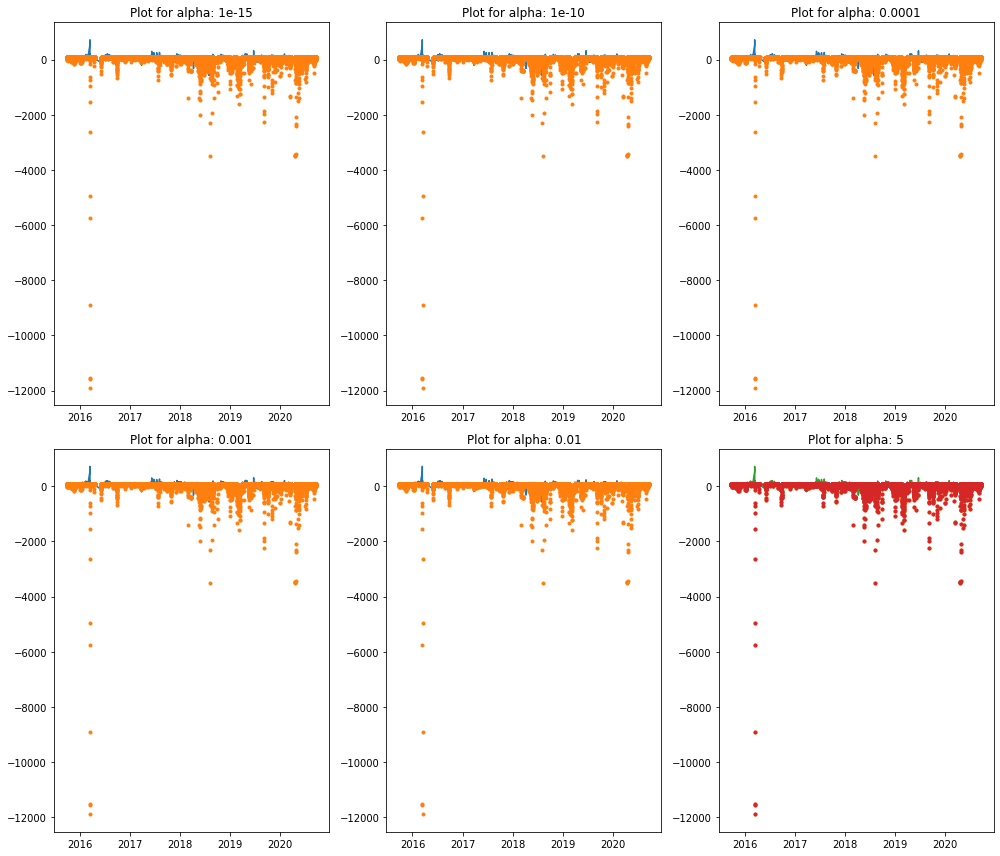

In [12]:
from sklearn.linear_model import Ridge
def MSridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['Zn_drop_act'])
    y_pred = ridgereg.predict(data[predictors])
    
    rcParams['figure.figsize'] = 14, 12
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data.index,y_pred)
        plt.plot(data.index, data['Zn_drop_act'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['Zn_drop_act'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

#Initialize predictors to be set of 15 powers of x
#predictors=['x']
#predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}


zndrop_predictors = ['104_Pb', '104_Zn', '104_Cu', '104_Ni', '104_Co', '104_Fe', '104_Mn',
       '104_Cr', '104_Ca', '104_Si', '104_Al', '104_Mg', '104_Fe2', '104_pH60_exp',
       '104_ORP', '104_NTU', '104_Ft', 'tk13_Zn', 'tk13_solids%',
       'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'DeZn_TK05_T',
       'H2S_tk01', 'H2S_tk02', 'tk05_Al', 'tk05_Ca', 'tk05_Co', 'tk05_Cr',
       'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni', 'tk05_Pb',
       'tk05_Si', 'tk05_Zn']

for i in range(10):
    MSridge_regression(DF_main_FULL_CLEAN, zndrop_predictors, alpha_ridge[i], models_to_plot)
    
    
ridgereg = Ridge(alpha=.001,normalize=True)
ridgereg.fit(DF_main_FULL_CLEAN[zndrop_predictors],DF_main_FULL_CLEAN['Zn_drop_act'])
y_pred = ridgereg.predict(DF_main_FULL_CLEAN[zndrop_predictors])

plt.tight_layout()
plt.plot(DF_main_FULL_CLEAN['Zn_drop_act'].index, y_pred)
plt.plot(DF_main_FULL_CLEAN['Zn_drop_act'].index, DF_main_FULL_CLEAN['Zn_drop_act'],'.')

reg_intercept = ridgereg.intercept_
reg_coef = ridgereg.coef_
    

#### Export the regression coefficients

In [15]:
df_reg_coef_intercepts_zndropPred = pd.DataFrame(reg_coef)
df_reg_coef_intercepts_zndropPred['ridgereg_intercept_ZnDropPred'] = reg_intercept

df_reg_coef_intercepts_zndropPred.columns = ['Parameters_coef', 'intercept']

df_reg_coef_intercepts_zndropPred.to_excel(r'C:\Users\v.t.flores\Documents\df_reg_coef_intercepts_zndropPred_rev2_20152020_plus_Sept.xlsx')

zndrop_predictors = ['104_Pb', '104_Zn', '104_Cu', '104_Ni', '104_Co', '104_Fe', '104_Mn',
       '104_Cr', '104_Ca', '104_Si', '104_Al', '104_Mg', '104_Fe2', '104_pH60_exp',
       '104_ORP', '104_NTU', '104_Ft', 'tk13_Zn', 'tk13_solids%',
       'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'DeZn_TK05_T',
       'H2S_tk01', 'H2S_tk02', 'tk05_Al', 'tk05_Ca', 'tk05_Co', 'tk05_Cr',
       'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni', 'tk05_Pb',
       'tk05_Si', 'tk05_Zn']

for i in range(0, len(df_reg_coef_intercepts_zndropPred['Parameters_coef'])):
    DF['Coef{}'.format(i)] = df_reg_coef_intercepts_zndropPred['Parameters_coef'][i]
#
#
#
DF['ZnDrop_pred'] = DF['104_Pb']*DF.Coef0 + \
                                      DF['104_Zn']*DF.Coef1 + \
                                      DF['104_Cu']*DF.Coef2 + \
                                      DF['104_Ni']*DF.Coef3 + \
                                      DF['104_Co']*DF.Coef4 + \
                                      DF['104_Fe']*DF.Coef5 + \
                                      DF['104_Mn']*DF.Coef6+\
                                      DF['104_Cr']*DF.Coef7 + \
                                      DF['104_Ca']*DF.Coef8 + \
                                      DF['104_Si']*DF.Coef9 + \
                                      DF['104_Al']*DF.Coef10 + \
                                      DF['104_Mg']*DF.Coef11 + \
                                      DF['104_Fe2']*DF.Coef12 + \
                                      DF['104_pH60_exp']*DF.Coef13 + \
                                      DF['104_ORP']*DF.Coef14+\
                                      DF['104_NTU']*DF.Coef15 + \
                                      DF['104_Ft']*DF.Coef16 + \
                                      DF['tk13_Zn']*DF.Coef17 + \
                                      DF['tk13_solids%']*DF.Coef18 + \
                                      DF['DeZn_Feed_Flow']*DF.Coef19 + \
                                      DF['DeZn_Feed_T']*DF.Coef20 + \
                                      DF['DeZn_TK05_T']*DF.Coef21 + \
                                      DF['H2S_tk01']*DF.Coef22 + \
                                      DF['H2S_tk02']*DF.Coef23 + \
                                      DF['tk05_Al']*DF.Coef24+\
                                      DF['tk05_Ca']*DF.Coef25 + \
                                      DF['tk05_Co']*DF.Coef26 + \
                                      DF['tk05_Cr']*DF.Coef27 + \
                                      DF['tk05_Cu']*DF.Coef28 + \
                                      DF['tk05_Fe']*DF.Coef29 + \
                                      DF['tk05_Mg']*DF.Coef30 + \
                                      DF['tk05_Mn']*DF.Coef31 + \
                                      DF['tk05_Ni']*DF.Coef32 + \
                                      DF['tk05_Pb']*DF.Coef33 + \
                                      DF['tk05_Si']*DF.Coef34 + \
                                      DF['tk05_Zn']*DF.Coef35+ reg_intercept

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
DF.to_excel(r'C:\Users\v.t.flores\Documents\Zn_drop_database_2015_2020.xlsx')

